Fitting 3 folds for each of 30 candidates, totalling 90 fits
✅ Best Threshold: 0.48, F1 Score: 0.6269
Accuracy: 0.7464503042596349
F1 Score: 0.6268656716417911

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.72      0.81       727
           1       0.51      0.81      0.63       259

    accuracy                           0.75       986
   macro avg       0.71      0.77      0.72       986
weighted avg       0.81      0.75      0.76       986



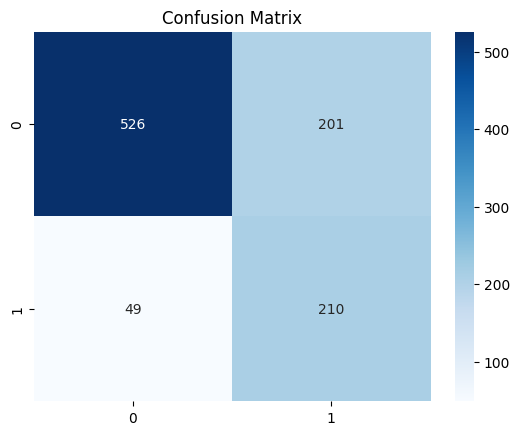

✅ Submission file saved: /kaggle/working/predictions.csv


In [1]:
# --- Libraries ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix, classification_report
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# --- Load Data ---
train_df = pd.read_csv('/kaggle/input/train-csv/train.csv')
test_df = pd.read_csv('/kaggle/input/test-csv/test.csv')
test_IDs = test_df['ID']

# --- Drop ID Columns ---
for col in ['ID', 'customerID']:
    if col in train_df.columns:
        train_df.drop(col, axis=1, inplace=True)
    if col in test_df.columns:
        test_df.drop(col, axis=1, inplace=True)

# --- Handle Missing ---
train_df.dropna(inplace=True)
test_df.dropna(inplace=True)

# --- Encode Categorical Features ---
label_encoders = {}
for col in train_df.select_dtypes(include='object').columns:
    unique_train = set(train_df[col].unique())
    unique_test = set(test_df[col].unique())
    new_categories = unique_test - unique_train
    if new_categories:
        most_frequent = train_df[col].mode()[0]
        test_df[col] = test_df[col].replace(list(new_categories), most_frequent)
    
    le = LabelEncoder()
    train_df[col] = le.fit_transform(train_df[col])
    test_df[col] = le.transform(test_df[col])
    label_encoders[col] = le

# --- Features and Target ---
X = train_df.drop('Churn', axis=1)
y = train_df['Churn']

# --- Train-Test Split ---
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# --- Class Imbalance Handling ---
scale_pos_weight = y_train.value_counts()[0] / y_train.value_counts()[1]

# --- Hyperparameter Grid ---
param_grid = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.7, 0.8, 1],
    'colsample_bytree': [0.7, 0.8, 1],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 2, 5],
    'min_child_weight': [1, 3, 5],
    'gamma': [0, 0.1, 0.5]
}

# --- Model Setup ---
model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='aucpr',
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    random_state=42
)

# --- Randomized Search for F1 ---
search = RandomizedSearchCV(
    model, param_distributions=param_grid,
    n_iter=30, scoring='f1',
    cv=3, verbose=2, random_state=42, n_jobs=-1
)
search.fit(X_train, y_train)

# --- Best Model ---
final_model = search.best_estimator_

# --- Predict Probabilities ---
y_probs = final_model.predict_proba(X_valid)[:, 1]

# --- Optimize Threshold for F1 ---
best_thresh = 0.5
best_f1 = 0
for thresh in np.arange(0.1, 0.9, 0.01):
    preds = (y_probs >= thresh).astype(int)
    score = f1_score(y_valid, preds)
    if score > best_f1:
        best_f1 = score
        best_thresh = thresh

print(f"✅ Best Threshold: {best_thresh:.2f}, F1 Score: {best_f1:.4f}")

# --- Final Evaluation ---
y_pred = (y_probs >= best_thresh).astype(int)
print("Accuracy:", accuracy_score(y_valid, y_pred))
print("F1 Score:", f1_score(y_valid, y_pred))
print("\nClassification Report:\n", classification_report(y_valid, y_pred))

# --- Confusion Matrix ---
sns.heatmap(confusion_matrix(y_valid, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# --- Predict on Test Set ---
test_probs = final_model.predict_proba(test_df)[:, 1]
test_preds = (test_probs >= best_thresh).astype(int)

# --- Submission ---
submission = pd.DataFrame({
    'ID': test_IDs,
    'Prediction': test_preds
})
submission.to_csv('/kaggle/working/predictions.csv', index=False)
print("✅ Submission file saved: /kaggle/working/predictions.csv")
